# Gaussian Subgoal Prediction

Right now we are actively working on two problems related to subgoal identification.

1. **Subgoal discovery** (offline) given unlabeled demonstration data. This is the problem that the BNIRL (Michini) and DPMIRL (Maske) seek to solve. This problem is cast within the inverse reinforcement learning (IRL) framework which uses the notion of Markov decision processes (MDPs).

2. **Subgoal prediction** (online) using the results from the previous step, and the current machine state and input, can we estimate the probability of the current subgoal or

$$P(z_i | O_i, \theta)$$

where $O_i$ is the $i^{th}$ observation (i.e., the $i^{th}$ measurement) and consists of a state-action pair: $$O_i = (s_i, a_i)$$
$z_i$ is the subgoal assignment at observation $i$, and $\theta$ are the  model parameters discovered in step 1 (**revisit**).

These two problems are closely related but may not assume the exact same generative model for the observation data. For instance, the subgoal discovery may use nonparametric Bayesian priors to allow for multiple subgoals, and be trained on expert data, whereas the prediction may assume a fixed number of subgoals, inherited from the discovery step, and should be able to infer subgoals of multiple operators with varying skill.

**Major outstanding questions:** some remaining questions to consider as you read
- Will task demonstration data from one (or multiple) operators be sufficient to infer the current subgoal of a random operator?
- What is the strict definition of a subgoal? In BNIRL they are points in the state space that give a reward only at that point.
- In what candidate set do we search for the subgoals? In BNIRL, it is the observation set.


___

___

## 1. Subgoal Discovery (Task Learning)

In this section we will explore some methods for discovering latent subgoals from the demonstration data. These methods are firmly rooted in inverse reinforcement learning (IRL), which uses the notion (and notation) of Markov decision processes (MDPs).

### 1.a. Bayesian Nonparametric Inverse Reinforcement Learning (BNIRL)

Michini, *et al.*, presented a Bayesian nonparametric approach to IRL (BNIRL) which partitioned the candidate reward function into several simple reward functions. The author suggested each partition could utilize a simple reward function, $R_g(s)$, at a single coordinate $g$, which could be considered a *subgoal* of the operator

$$ R_g(s) = 
\begin{cases}
	c 	&  s = g \\
	0 	&  s \neq g
\end{cases}
$$

where c is a constant reward. The candidate subgoal set $\mathcal{G}$ is formed by the demonstration states, *i.e.*, it is assumed that the demonstrator reaches all subgoals at some point in the demonstration, although not necessarily in an optimal fashion. In [Michini], the BNIRL algorithm utilizes a Bayesian nonparametric generative model for the subgoal partition assignment of the form

$$
\underbrace{P(z_i|z_{-i}, \mathcal{O})}_{\text{assignment posterior}} \propto \underbrace{P(z_i|z_{-i})}_{CRP} \underbrace{P(O_i|R_i)}_{likelihood}
$$

where the assignment prior is a *Chinese restaurant process (CRP)* [reference], according to

$$
	P(z_i|z_{-i}) = 
	\begin{cases}
		\frac{\sum(z_{-i}=j)}{N-1+\eta} 	& 	\text{If partition $j$ already exists} \\
		\frac{\eta}{N - 1 + \eta} 			& 	\text{If partition $j$ is new}
	\end{cases}
$$

with hyperparameter $\eta$ controlling the tendency to form new partitions. The *action likelihood* is formed by an exponential rationality model [source]

$$
	P(O_i|R_{z_i}) = P(a_i | s_i, z_i) \propto e^{\alpha Q^*(s_i, a_i, R_{z_i})}
$$

where the optimal value function must be solved to compute $Q^*$. One major contribution of the BNIRL approach was to approximate $Q^*$ with an action comparison, such that

$$
	P(O_i|R_{z_i}) = P(a_i | s_i, z_i) \propto e^{-\alpha ||a_i - a_{CL}||_2 }
$$

In other words, given some state $s_i$ and subgoal $z_i$, the most likely actions are those that approach the action of a closed-loop controller $a_{CL}$ whose setpoint is the subgoal $z_i$. This *action comparison* makes computing the action likelihood amenable to continuous state and action spaces without discretization. However, it does assume that the demonstrator is capable of coordinating his input actions such that they universally (across all input axes) approach the operator's goal state. Testing this with high dimensional input spaces, we discover that this definition of action comparison is too strict.

In BNIRL, Gibbs sampling over the partition posterior is used to form the joint posterior, where the necessary condition *exchangeability* is shown in [Cite].

### 1.b Dirichlet Process Means Inverse Reinforcement Learning (DPMIRL)

*TODO* Add review from notes.

___

## 2. Subgoal Prediction

We suggest two modifications to the Bayesian generative model which can be  easily implemented for online prediction, given some modified results from the subgoal discovery step:

- Subgoals are drawn each cycle from a **multivariate normal distribution**, such that the location of the $z^{th}$ subgoal is

$$\mathbf{g}_z \sim \mathcal{N}(\boldsymbol{\mu}_z, \mathbf{\Sigma}_z)$$

- The action likelihood should prioritize any actions which move *towards* the largest mass of this subgoal distribution (this is made precise in Sec 2.a.).

This provides a method of discriminating between known subgoals in the workspace conditioned on the instantaneous state and input vectors, and providing control assistance which is tempered by uncertainty in the setpoint.

___

### 2.a. Gaussian Action Likelihood

Let us assume that from our offline subgoal discovery, we can approximate parameters, $\boldsymbol{\mu}_z, \mathbf{\Sigma}_z$ for all $z \in \mathcal{Z}$, where $\mathcal{Z} = \{1, 2, ..., k\}$.

Our goal is to define the probability that a particular action from a particular state seeks subgoal $\mathbf{g}_z$, which belongs to a multivariate normal (MVN) distribution.

This can be achieved in the multivariate Gaussian case by integrating the multivariate probability density function over a custom domain, which we define as the action-targeted domain (ATD), denoted $\mathcal{D}$. The domain is defined in the actuator state-space coordinates $\mathcal{D} \subset \mathbb{R}^m$ according to the following:

In axes in which the action input is *null*, the domain is infinite (corresponding to marginalizing out the null input variable(s)). In the active input axes the domain is semi-finite, bounded by the current state and infinity in the action direction.

#### Scalar Formulation (**needs work**)

$$\mathcal{D} = \mathcal{D}_1 \times \mathcal{D}_2 \times \mathcal{D}_3 \times \mathcal{D}_4$$

or, $\mathcal{D}$ is the Cartesian product of the one dimensional domain in each input axis. 

$$\mathcal{D}_j \subset \mathbb{R}$$

where

$$\mathcal{D}_j = 
\begin{cases}
    [s_{ij}, +\infty) 	&  a_{ij} > 0 \\
	(-\infty, s_{ij}] 	&  a_{ij} < 0 \\
    (-\infty, +\infty)  &  a_{ij} = 0
\end{cases}
$$

**Add visualization**

___


Then our action likelihood is

$$\Pr(\mathbf{a}_i | \mathbf{s}_i, \mathbf{g}_z) = \int ... \int_\mathcal{D} f_z(x_1, x_2, ..., x_m) \ dx_1 ... dx_m $$

where $f_z(x_1, x_2, ..., x_m)$ is the probability density function (PDF) of subgoal $g_z$

$$f_z(\mathbf {x}) = {\frac {\exp \left(-{\frac {1}{2}}({\mathbf {x} }-{\boldsymbol {\mu}_z})^{\mathrm {T} }{\boldsymbol {\Sigma }_z}^{-1}({\mathbf {x} }-{\boldsymbol {\mu }_z})\right)}{\sqrt {|2\pi {\boldsymbol {\Sigma }_z}|}}}$$

This integration can be computed by Alan Genz's multivariate normal functions in scipy. However, in most cases the action will only be along one or two unit vector directions, such that for the other directions $a \cdot \hat{u}_j = 0$ in this case, the domain in the $j^{th}$ direction is infinite. Computing this integral simply corresponds to marginalizing out the $j^{th}$ variable. But with multivariate normal distributions we can simply drop the covariances from the covariance matrix and compute over the remaining variables.

### Example: 2D State Space

Consider a 2-dimensional space with some given subgoal demonstration data.

In [1]:
%matplotlib inline

import numpy as np
from sklearn import mixture

import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools

from scipy import linalg
from scipy.stats import mvn
import scipy.stats as stats

mpl.style.use('mitch-exp')

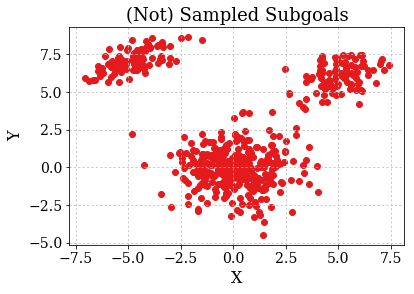

In [2]:
# Generate some multivariate gaussian data
def gen_data():
    np.random.seed(10)
    obs = np.concatenate((1.5*np.random.randn(300, 2),
                          np.random.multivariate_normal(mean=[5, 6], cov=[[1, 0.3], [0.5, 1]], size=(100)),
                          np.random.multivariate_normal(mean=[-5, 7], cov=[[1.5, 0.7], [0.5, 0.6]], size=(100))))
    return obs

obser = gen_data()
plt.scatter(*np.split(obser, 2, axis=1))
plt.title('(Not) Sampled Subgoals')
plt.xlabel('X')
plt.ylabel('Y');

___
Run a Gaussian Mixture Model with k=3 components on the above data and get means and covariances.

The 0'th subgoal distribution is located at [ 0.10229224 -0.06022521] 
 with covariance: 
 [[ 2.13602159 -0.03655564]
 [-0.03655564  1.86771398]].
The 1'th subgoal distribution is located at [-4.78298662  7.08490684] 
 with covariance: 
 [[ 1.12522456  0.50220192]
 [ 0.50220192  0.52829069]].
The 2'th subgoal distribution is located at [ 5.0089917   6.04205016] 
 with covariance: 
 [[ 1.04874624  0.33247049]
 [ 0.33247049  0.78417994]].


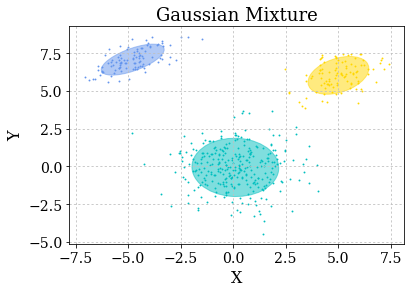

In [3]:
col = ['navy', 'c', 'cornflowerblue', 'gold', 'darkorange']

def plot_results(X, Y_, means, covariances, title):
    ax = plt.gca()
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, col[1:4])):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(title)
    
gmm = mixture.GaussianMixture(n_components=3, covariance_type='full').fit(obser)
plot_results(obser, gmm.predict(obser), gmm.means_, gmm.covariances_, 
             'Gaussian Mixture')

for i in range(3):
    print('The %i\'th subgoal distribution is located at %s \n with covariance: \n %s.') % (i, gmm.means_[i], gmm.covariances_[i])

___
Consider a test case from a random state.

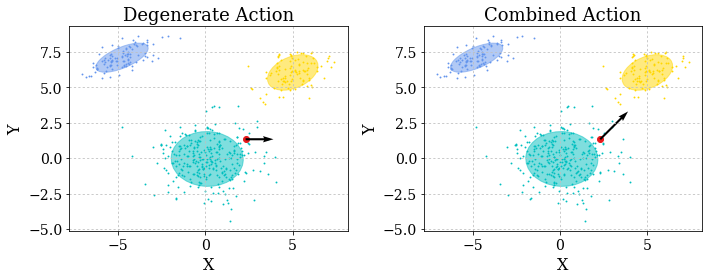

In [4]:
np.random.seed(30)
states = np.random.uniform([-8, -4], [8, 10], size=(1, 2))

fig = plt.figure(figsize=(10, 4))

# Action in one dimension
ax1 = plt.subplot(1, 2, 1)
plot_results(obser, gmm.predict(obser), gmm.means_, gmm.covariances_, 
             'Degenerate Action')
plt.scatter(*np.split(states, 2, axis=1))
plt.quiver(states.T[0], states.T[1], 1, 0, scale=10)

# Combined action
ax2 = plt.subplot(1, 2, 2)
plot_results(obser, gmm.predict(obser), gmm.means_, gmm.covariances_, 
             'Combined Action')
plt.scatter(*np.split(states, 2, axis=1))
plt.quiver(states.T[0], states.T[1], 1, 1, scale=10);

plt.tight_layout()

In [5]:
# Function for integrating multivariate normal approach
def action_likelihoods(states, actions, means, covs):
    # Warning: if only one state, or only one subgoal, may need to add extra axis
    action_likelihoods = np.zeros((states.shape[0], means.shape[0]))
    indicator = np.zeros(action_likelihoods.shape)
    for i in xrange(states.shape[0]):
        for g in xrange(means.shape[0]):
            low = np.zeros(states.shape[1])
            upp = np.copy(low)
            for j in xrange(states.shape[1]):
                if actions[i, j] < 0:
                    low[j] = means[g, j] - 10 * covs[g, j, j]
                    upp[j] = states[i, j]
                elif actions[i, j] > 0:
                    low[j] = states[i, j]
                    upp[j] = means[g, j] + 10 * covs[g, j, j]
                else:  # Yields probability 1
                    low[j] = means[g, j] - 10 * covs[g, j, j]
                    upp[j] = means[g, j] + 10 * covs[g, j, j]
            action_likelihoods[i, g], indicator[i, g] = mvn.mvnun(low, upp, means[g], covs[g])
    return action_likelihoods, indicator

def plot_action_likelihoods(action_likelihoods, title, ax):
    index = np.arange(action_likelihoods.shape[0])
    bar_width = 0.5
    opacity = 0.4

    ax.bar(index, action_likelihoods, bar_width,
                     alpha=opacity,
                     color=col[1:4])
    plt.figure(fig.number)
    plt.xlabel('Subgoal')
    plt.ylabel('Action Likelihood')
    plt.title(title)
    plt.xticks(index, ('1', '2', '3'))

In [6]:
set3 = plt.get_cmap('Set3').colors

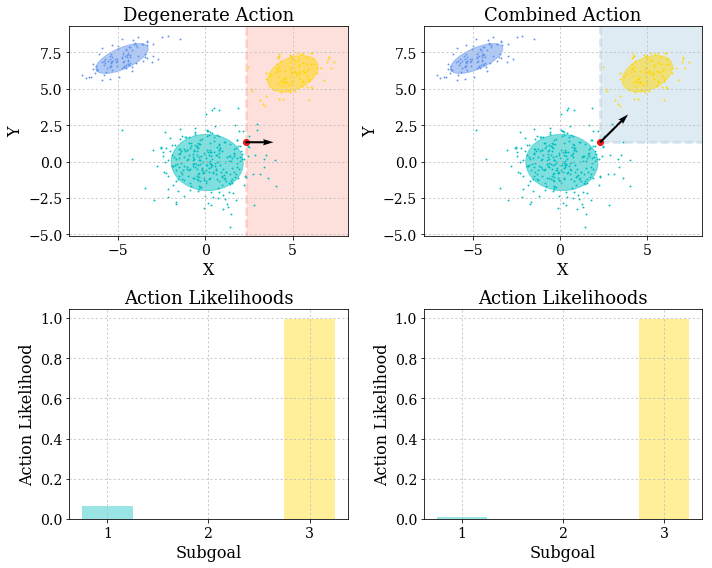

In [7]:
fig = plt.figure(figsize=(10, 8))

# Action in one dimension
ax1 = plt.subplot(2, 2, 1)
plot_results(obser, gmm.predict(obser), gmm.means_, gmm.covariances_, 
             'Degenerate Action')
plt.scatter(*np.split(states, 2, axis=1))
plt.quiver(states.T[0], states.T[1], 1, 0, scale=10)

# Combined action
ax2 = plt.subplot(2, 2, 2)
plot_results(obser, gmm.predict(obser), gmm.means_, gmm.covariances_, 
             'Combined Action')
plt.scatter(*np.split(states, 2, axis=1))
plt.quiver(states.T[0], states.T[1], 1, 1, scale=10);

ax1.add_patch(mpl.patches.Rectangle((states.T[0], -6), 20, 20, zorder=-10, color=set3[3], ec=set3[3], alpha=0.25, lw=3, ls='--'))
ax2.add_patch(mpl.patches.Rectangle((states.T[0], states.T[1]), 20, 20, zorder=-10, color=set3[4], alpha=0.25, ec=set3[4], lw=3, ls='--'))

# Compute multivariate normal probability mass for each subgoal
ll, _ = action_likelihoods(np.vstack((states, states)), np.array([[1, 0], [1, 1]]), gmm.means_, gmm.covariances_)

# plt.figure(fig.number)
ax3 = plt.subplot(2, 2, 3)
plot_action_likelihoods(ll[0], 'Action Likelihoods', ax3)

ax4 = plt.subplot(2, 2, 4)
plot_action_likelihoods(ll[1], 'Action Likelihoods', ax4)

plt.tight_layout()

# Second Example

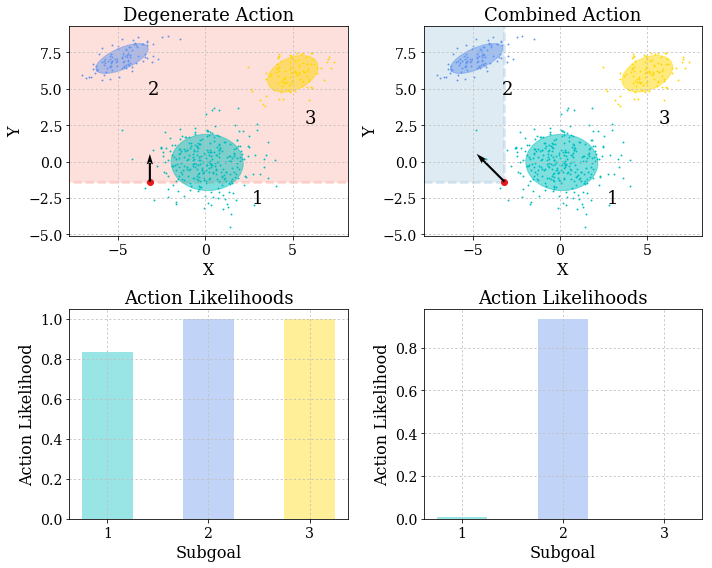

In [24]:
np.random.seed(60)
states = np.random.uniform([-8, -4], [8, 10], size=(1, 2))

fig = plt.figure(figsize=(10, 8))

# Action in one dimension
ax1 = plt.subplot(2, 2, 1)
plot_results(obser, gmm.predict(obser), gmm.means_, gmm.covariances_, 
             'Degenerate Action')
plt.scatter(*np.split(states, 2, axis=1))
plt.quiver(states.T[0], states.T[1], 0, 1, scale=10)
ax1.text(-3, 5, '2', color='k', fontsize=18, 
         horizontalalignment='center', verticalalignment='center')
ax1.text(3, -2.5, '1', color='k', fontsize=18,
         horizontalalignment='center', verticalalignment='center')
ax1.text(6, 3, '3', color='k', fontsize=18,
         horizontalalignment='center', verticalalignment='center')



# Combined action
ax2 = plt.subplot(2, 2, 2)
plot_results(obser, gmm.predict(obser), gmm.means_, gmm.covariances_, 
             'Combined Action')
plt.scatter(*np.split(states, 2, axis=1))
plt.quiver(states.T[0], states.T[1], -1, 1, scale=10);

ax2.text(-3, 5, '2', color='k', fontsize=18,
         horizontalalignment='center', verticalalignment='center')
ax2.text(3, -2.5, '1', color='k', fontsize=18,
         horizontalalignment='center', verticalalignment='center')
ax2.text(6, 3, '3', color='k', fontsize=18,
         horizontalalignment='center', verticalalignment='center')



ax1.add_patch(mpl.patches.Rectangle((-20, states.T[1]), 40, 20, zorder=-10, color=set3[3], ec=set3[3], alpha=0.25, lw=3, ls='--'))
ax2.add_patch(mpl.patches.Rectangle((states.T[0], states.T[1]), -20, 20, zorder=-10, color=set3[4], alpha=0.25, ec=set3[4], lw=3, ls='--'))

# Compute multivariate normal probability mass for each subgoal
ll, _ = action_likelihoods(np.vstack((states, states)), np.array([[0, 1], [-1, 1]]), gmm.means_, gmm.covariances_)

# Normalize
# ll /= np.expand_dims(np.sum(ll, axis=1), axis=-1)

# plt.figure(fig.number)
ax3 = plt.subplot(2, 2, 3)
plot_action_likelihoods(ll[0], 'Action Likelihoods', ax3)

ax4 = plt.subplot(2, 2, 4)
plot_action_likelihoods(ll[1], 'Action Likelihoods', ax4)

plt.tight_layout()
plt.savefig('figs/gaussian_prediction_2.pdf')

In [16]:
gmm.means_

array([[ 0.10229224, -0.06022521],
       [-4.78298662,  7.08490684],
       [ 5.0089917 ,  6.04205016]])

Hopefully the higher dimensional input will be more discriminative. But the action likelihood can always be combined with a transition prior.

Also, the likelihoods will be normalized in practice and then mapped to a reasonable blending parameter range. The mapping should ensure that the human operator retains some baseline level of authority in all situations.